# <p style="padding:20px;background-color:#ffe7a0;margin:0;color:(0,0,0);font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">FORECASTING CPI IN VIETNAM WITH DEEP LEARNING</p>

## <p style="padding:5px;background-color:#034235;margin:0;color:#ffe7a0;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">1. Import Libraries and Data Loading</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Đặt seed cố định
seed = 25
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
data = pd.read_excel("Data-cpi-Vietnam.xlsx")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

,cpi
date,
2002-01-15,29.794797
2002-02-15,30.450282
2002-03-15,30.206680
2002-04-15,30.206680
2002-05-15,30.297300


In [4]:
data.tail()

,cpi
date,
2023-08-15,112.0720
2023-09-15,113.2823
2023-10-15,113.3754
2023-11-15,113.6572
2023-12-15,113.7888


## <p style="padding:5px;background-color:#034235;margin:0;color:#ffe7a0;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">2. Phân tích biến CPI</p>

In [5]:
# Split the data into train and test sets
des = data.loc['2002-01':'2022-12']
des.tail()

,cpi
date,
2022-08-15,108.852808
2022-09-15,109.286151
2022-10-15,109.444834
2022-11-15,109.868604
2022-12-15,109.854871


In [6]:
# 1. Thống kê mô tả
descriptive_stats = des['cpi'].describe()

# 2. Kiểm tra độ lệch và độ nhọn
skewness = des['cpi'].skew()
kurtosis = des['cpi'].kurt()

# Hiển thị kết quả
results = {
    "Descriptive Statistics": descriptive_stats,
    "Skewness": skewness,
    "Kurtosis": kurtosis
}

results

{'Descriptive Statistics': count    252.000000
 mean      71.027318
 std       26.877677
 min       29.794797
 25%       41.540422
 50%       78.293506
 75%       94.441492
 max      109.868604
 Name: cpi, dtype: float64,
 'Skewness': -0.23199097768713617,
 'Kurtosis': -1.4846074494845414}

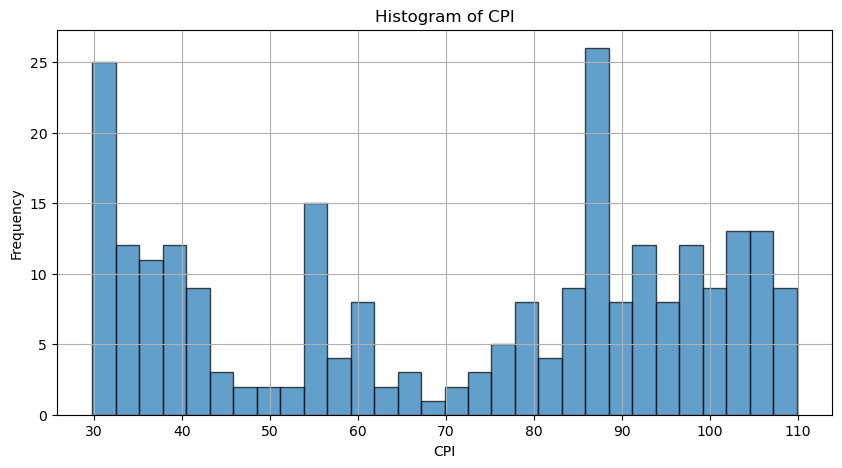

In [7]:
# 2. Histogram (Phân phối dữ liệu)
plt.figure(figsize=(10, 5))
plt.hist(des['cpi'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show();

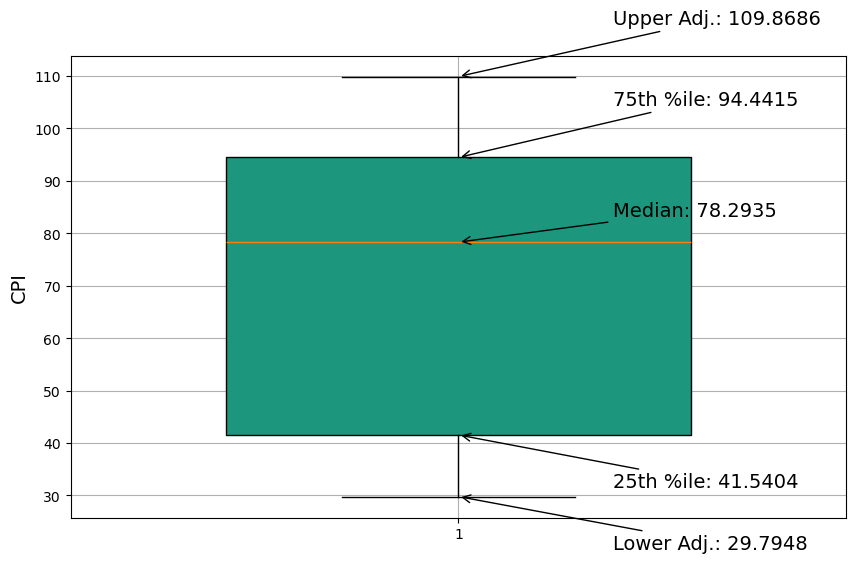

In [8]:
dff = des['cpi'].dropna()  # Ensure no NaN values
median = np.median(dff)
q1 = np.percentile(dff, 25)
q3 = np.percentile(dff, 75)
iqr = q3 - q1
lower_adj = max(min(dff), q1 - 1.5 * iqr)
upper_adj = min(max(dff), q3 + 1.5 * iqr)

# Now, the plotting code will work
plt.figure(figsize=(10, 6))

# Plot the boxplot
box = plt.boxplot(dff, patch_artist=True, widths=0.6, showmeans=False)
plt.ylabel('CPI', fontsize=14)

# Style boxplot with orange color
for patch in box['boxes']:
    patch.set_facecolor('#1d967e')

# Adding annotations with larger font size
plt.annotate(f"Median: {median:.4f}", xy=(1, median), xytext=(1.2, median + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"25th %ile: {q1:.4f}", xy=(1, q1), xytext=(1.2, q1 - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"75th %ile: {q3:.4f}", xy=(1, q3), xytext=(1.2, q3 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"Lower Adj.: {lower_adj:.4f}", xy=(1, lower_adj), xytext=(1.2, lower_adj - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"Upper Adj.: {upper_adj:.4f}", xy=(1, upper_adj), xytext=(1.2, upper_adj + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')

# Remove grid
plt.grid(True)
plt.show();

## <p style="padding:5px;background-color:#034235;margin:0;color:#ffe7a0;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">3. Data Preprocessing</p>

In [9]:
# Split the data into train and test sets
train_data = data.loc['2002-01':'2022-12']
test_data = data.loc['2023-01':'2023-12']

# Prepare the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
cpi_data = train_data['cpi'].values
cpi_data = np.reshape(cpi_data, (-1, 1))
cpi_scaled = scaler.fit_transform(cpi_data)

# Create training data
time_step = 12
X, y = [], []
for i in range(time_step, len(cpi_scaled)):
    X.append(cpi_scaled[i-time_step:i, 0])
    y.append(cpi_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

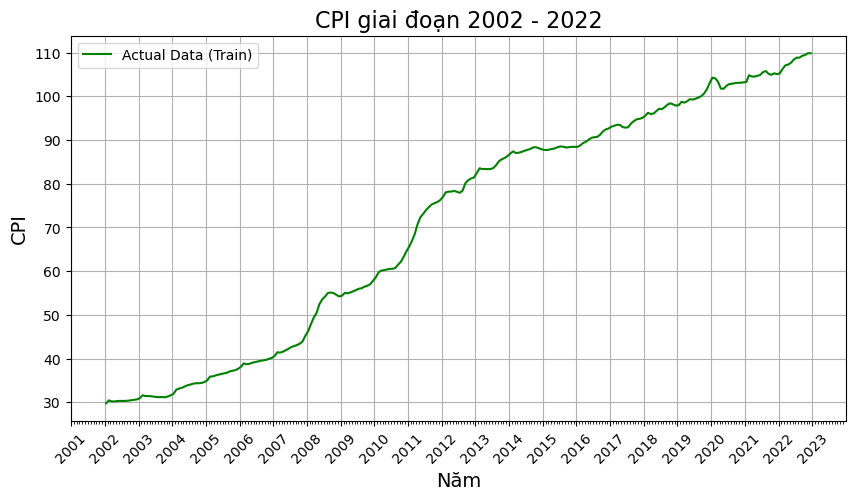

In [10]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, cpi_data, label='Actual Data (Train)', color='green')
# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Hiển thị mỗi năm
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Hiển thị mỗi tháng nhỏ (nếu cần)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Định dạng hiển thị chỉ năm
plt.xticks(rotation=45) # Xoay nhãn trục x để dễ nhìn hơn
# Đặt nhãn và tiêu đề
plt.xlabel('Năm', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.title('CPI giai đoạn 2002 - 2022', fontsize=16)
plt.legend()
plt.grid(True)
plt.show();

## <p style="padding:5px;background-color:#034235;margin:0;color:#ffe7a0;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">4. Mô hình RNN</p>

In [11]:
# Train the model
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(X, y, epochs=128, batch_size=32, verbose=1)

Epoch 1/128


2024-12-31 15:27:10.608542: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 1s 5ms/step - loss: 0.5044 - accuracy: 0.0000e+00
Epoch 2/128
8/8 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.0042
Epoch 3/128
8/8 [==============================] - 0s 4ms/step - loss: 0.2506 - accuracy: 0.0000e+00
Epoch 4/128
8/8 [==============================] - 0s 4ms/step - loss: 0.2181 - accuracy: 0.0000e+00
Epoch 5/128
8/8 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.0042
Epoch 6/128
8/8 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.0000e+00
Epoch 7/128
8/8 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.0042
Epoch 8/128
8/8 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.0042
Epoch 9/128
8/8 [==============================] - 0s 4ms/step - loss: 0.0993 - accuracy: 0.0042
Epoch 10/128
8/8 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.0042
Epoch 11/128
8/8 [=======

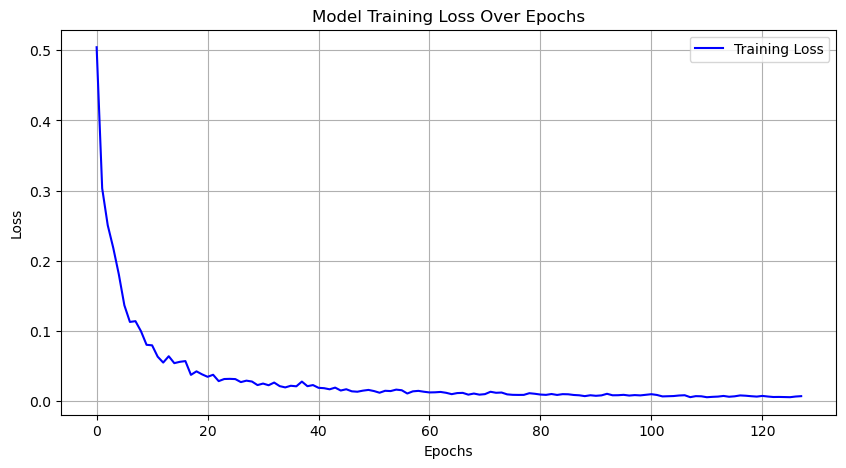

In [13]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show();

In [14]:
# Calculate residuals and standard deviation
train_predictions = model.predict(X, verbose=0)
train_predictions = scaler.inverse_transform(train_predictions)
actual_values = scaler.inverse_transform(y.reshape(-1, 1))
residuals = actual_values - train_predictions
residual_std = np.std(residuals)

In [15]:
# Predict future values
future_predictions = []
last_sequence = cpi_scaled[-time_step:]  # Last sequence from the training dataset

for _ in range(12):  # Predict 12 months ahead
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1), verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)  # Update sequence with the new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [16]:
# Create upper and lower bounds for the 95% confidence interval
future_upper_bound = future_predictions + 1.96 * residual_std
future_lower_bound = future_predictions - 1.96 * residual_std

# Create future dates
future_dates = pd.date_range(start=train_data.index.max(), periods=13, freq='M')[1:]

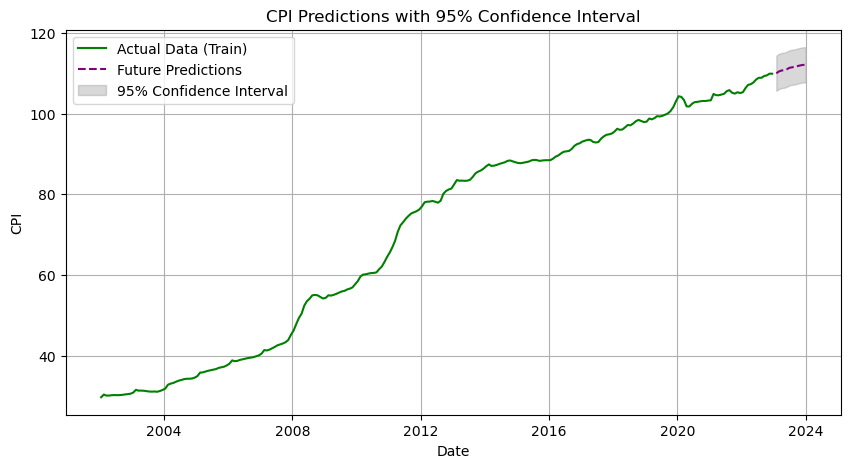

In [17]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, cpi_data, label='Actual Data (Train)', color='green')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='purple', linestyle='dashed')
plt.fill_between(future_dates, future_lower_bound.flatten(), future_upper_bound.flatten(), color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Predictions with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show();

In [18]:
rmse = np.sqrt(mean_squared_error(test_data, future_predictions)) # Tính RMSE
mae = mean_absolute_error(test_data, future_predictions) # Tính MAE
mse = mean_squared_error(test_data, future_predictions) # Tính MSE
mape = np.mean(np.abs((test_data - future_predictions) / test_data)) * 100 # Tính MAPE

# In kết quả
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Root Mean Squared Error (RMSE): 1.0068
Mean Absolute Error (MAE): 0.8379
Mean Squared Error (MSE): 1.0137
Mean Absolute Percentage Error (MAPE): 0.74%


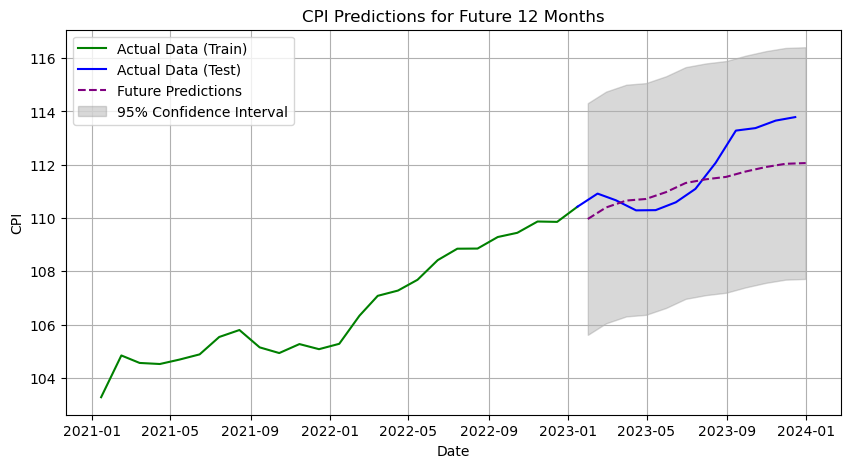

In [19]:
# Split the data into train and test sets
df_gon = data.loc['2021-01':'2023-01']
a = df_gon['cpi'].values

test_data = data.loc['2023-01':'2023-12']
b = test_data['cpi'].values
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df_gon.index, a, label='Actual Data (Train)', color='green')
plt.plot(test_data.index, b, label='Actual Data (Test)', color='blue')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='purple', linestyle='dashed')
plt.fill_between(future_dates, future_lower_bound.flatten(), 
                 future_upper_bound.flatten(), color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Predictions for Future 12 Months')
plt.legend()
plt.grid(True)
plt.show();

In [20]:
# Xuất kết quả dự báo ra file Excel
output_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted CPI': future_predictions.flatten()
})

# Xuất ra file Excel
output_file = "Future_CPI_Predictions_RNN.xlsx"
output_predictions.to_excel(output_file, index=False)
output_file

'Future_CPI_Predictions_RNN.xlsx'

In [21]:
output_predictions

,Date,Predicted CPI
0,2023-01-31,109.962494
1,2023-02-28,110.395462
2,2023-03-31,110.654648
3,2023-04-30,110.714020
4,2023-05-31,110.972443
5,2023-06-30,111.314362
6,2023-07-31,111.453392
7,2023-08-31,111.543594
8,2023-09-30,111.745049
9,2023-10-31,111.914825


## <p style="padding:5px;background-color:#034235;margin:0;color:#ffe7a0;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">5. Mô hình LSTM</p>

In [22]:
# Đặt seed cố định
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Prepare the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
cpi_data = train_data['cpi'].values
cpi_data = np.reshape(cpi_data, (-1, 1))
cpi_scaled = scaler.fit_transform(cpi_data)

In [23]:
# Create training data
time_step = 24
X, y = [], []
for i in range(time_step, len(cpi_scaled)):
    X.append(cpi_scaled[i-time_step:i, 0])
    y.append(cpi_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [24]:
# Build the model using LSTM
model = Sequential()
model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Train the model without shuffling
history = model.fit(X, y, epochs=128, batch_size=32, verbose=1, shuffle=False)

Epoch 1/128
8/8 [==============================] - 2s 17ms/step - loss: 0.1749
Epoch 2/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0920
Epoch 3/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0546
Epoch 4/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0145
Epoch 5/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0255
Epoch 6/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0140
Epoch 7/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0082
Epoch 8/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0082
Epoch 9/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0062
Epoch 10/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0064
Epoch 11/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0059
Epoch 12/128
8/8 [==============================] - 0s 14ms/step - loss: 0.0061
Epoch 13/128
8/8 [==============================]

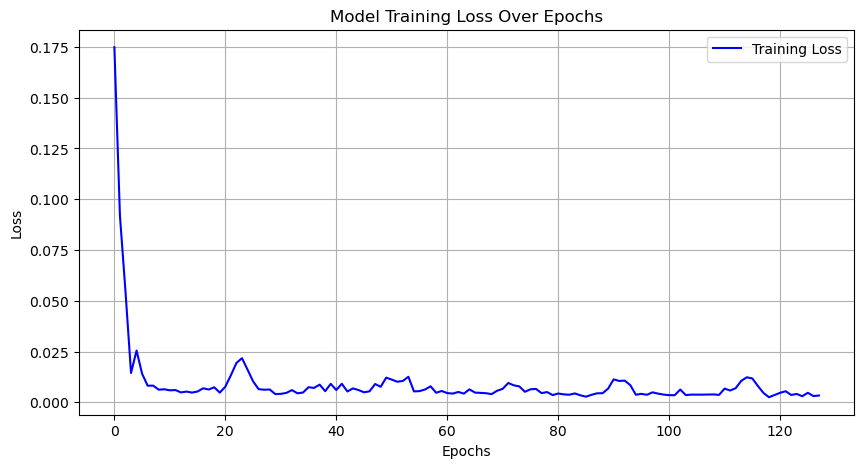

In [26]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show();

In [27]:
# Calculate residuals and standard deviation
train_predictions = model.predict(X, verbose=0)
train_predictions = scaler.inverse_transform(train_predictions)
actual_values = scaler.inverse_transform(y.reshape(-1, 1))
residuals = actual_values - train_predictions
residual_std = np.std(residuals)

In [28]:
# Predict future values
future_predictions = []
last_sequence = cpi_scaled[-time_step:]  # Last sequence from the training dataset

for _ in range(12):  # Predict 12 months ahead
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1), verbose=0)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)  # Update sequence with the new prediction

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create upper and lower bounds for the 95% confidence interval
future_upper_bound = future_predictions + 1.96 * residual_std
future_lower_bound = future_predictions - 1.96 * residual_std

# Create future dates
future_dates = pd.date_range(start=train_data.index.max(), periods=13, freq='M')[1:]

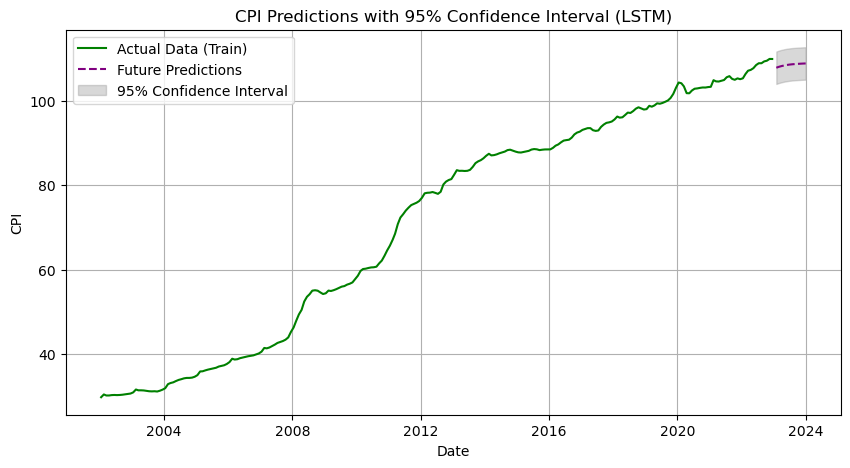

In [29]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, cpi_data, label='Actual Data (Train)', color='green')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='purple', linestyle='dashed')
plt.fill_between(future_dates, future_lower_bound.flatten(), future_upper_bound.flatten(), color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Predictions with 95% Confidence Interval (LSTM)')
plt.legend()
plt.grid(True)
plt.show();

In [30]:
rmse = np.sqrt(mean_squared_error(test_data, future_predictions)) # Tính RMSE
mae = mean_absolute_error(test_data, future_predictions) # Tính MAE
mse = mean_squared_error(test_data, future_predictions) # Tính MSE
mape = np.mean(np.abs((test_data - future_predictions) / test_data)) * 100 # Tính MAPE

# In kết quả
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Root Mean Squared Error (RMSE): 3.4443
Mean Absolute Error (MAE): 3.2441
Mean Squared Error (MSE): 11.8632
Mean Absolute Percentage Error (MAPE): 2.89%


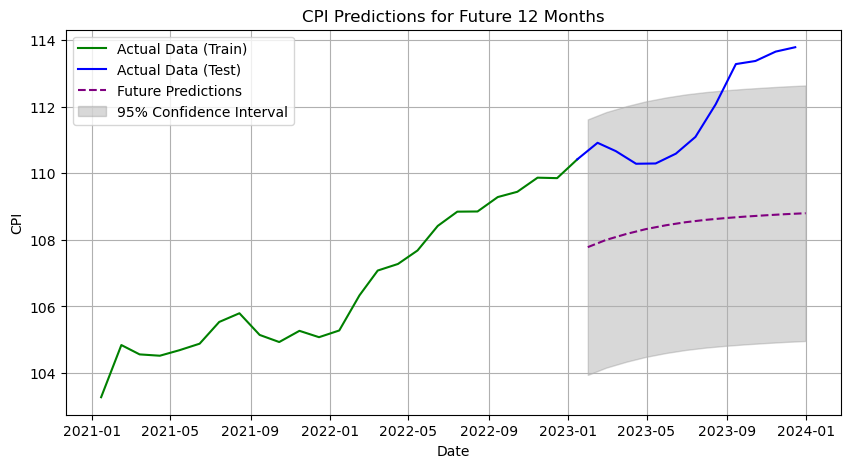

In [31]:
# Split the data into train and test sets
# df_gon = data.loc['2021-01':'2023-01']
# a = df_gon['cpi'].values

# test_data = data.loc['2023-01':'2023-12']
b = test_data['cpi'].values
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df_gon.index, a, label='Actual Data (Train)', color='green')
plt.plot(test_data.index, b, label='Actual Data (Test)', color='blue')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='purple', linestyle='dashed')
plt.fill_between(future_dates, future_lower_bound.flatten(), 
                 future_upper_bound.flatten(), color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Predictions for Future 12 Months')
plt.legend()
plt.grid(True)
plt.show();

In [32]:
# Xuất kết quả dự báo ra file Excel
output_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted CPI': future_predictions.flatten()
})

# Xuất ra file Excel
output_file = "Future_CPI_Predictions_LSTM.xlsx"
output_predictions.to_excel(output_file, index=False)
output_file

'Future_CPI_Predictions_LSTM.xlsx'

In [33]:
output_predictions

,Date,Predicted CPI
0,2023-01-31,107.781120
1,2023-02-28,107.998085
2,2023-03-31,108.176437
3,2023-04-30,108.322693
4,2023-05-31,108.439247
5,2023-06-30,108.530464
6,2023-07-31,108.601593
7,2023-08-31,108.656174
8,2023-09-30,108.699783
9,2023-10-31,108.738281


<div style="text-align:center;">
    <strong><span style="color:#034235;">Thanks for reading this post</span></strong>
</div>

_______
_Make by_**<span style="color:#034235;"> Le Hong Ngoc (Lucas),</span>**
### <p style="background-color:#034235;font-family:newtimeroman;color:#ffe7a0;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>
______
<div style="text-align:center;">
    <img src="https://github.com/LeHongNgoc3820/Lucas_viet_Blog/blob/b5e2de5a812292889e793b719572d06f3ababf2d/Logo%20ta%CC%81ch%20ne%CC%82%CC%80n.png?raw=true"
         style="width:200px;height:200px;">
</div>

**<span style="color:#034235;"> You can contact with me on:</span>**
+ **Gmail**: lehongngoc.work@gmail.com
+ **GitHub**: [LeHongNgoc3820](https://github.com/LeHongNgoc3820)
+ **Linkedln**: [Ngoc Le Hong](https://www.linkedin.com/in/ngoc-le-hong-44131b21a/)
+ **Website**: [Le Hong Ngoc](https://sites.google.com/view/lehongngocvn)